In [1]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 26.6 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=dee27f238c6fce648b17f545efd1481d81a5842224a431474a9d7f8b89ad18ff
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from tqdm import tqdm

# Load dataset

In [4]:
cora = Planetoid(root="./", name="Cora", split="public")
cora_dataset = cora[0]
cora_dataset

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
# Print size of train, validation, and test set
print(cora_dataset.train_mask.sum())
print(cora_dataset.val_mask.sum())
print(cora_dataset.test_mask.sum())

tensor(140)
tensor(500)
tensor(1000)


# Define Hyperparameters

In [6]:
args = {
    "learning_rate": 0.01,
    "num_epochs": 100,
    "hidden_size": 64,
    "experiment description": "Two-hop GAT Network, Adam optimizer."
}

# Define Network and Optimizer

In [7]:
class GAT(torch.nn.Module):
    def __init__(self, input_features, hidden_size, num_classes, training=True):
        super().__init__()
        self.conv1 = GATConv(in_channels=input_features, out_channels=hidden_size // 8, heads=8)
        self.conv2 = GATConv(hidden_size, num_classes, heads=1)

        self.act1 = nn.ELU()
        self.drop1 = nn.Dropout(p=0.6)
        self.drop2 = nn.Dropout(p=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.drop1(x)
        x, (edge_idx1, alphas1) = self.conv1(x, edge_index, return_attention_weights=True)
        x = self.act1(x)
        
        x = self.drop2(x)
        x, (edge_idx2, alphas2) = self.conv2(x, edge_index, return_attention_weights=True)
        return F.softmax(x, dim=1), (edge_idx1, alphas1, edge_idx2, alphas2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(cora_dataset.num_node_features, hidden_size=args["hidden_size"], num_classes=cora.num_classes).to(device)

cora_dataset = cora_dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"], weight_decay=5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=args["learning_rate"], momentum=0.9)

# Visualization

In [9]:
def plot_loss_curves(train_losses, val_losses):
    assert len(train_losses) == len(val_losses), "Inconsistent plotting sizes."
    
    time = list(range(args["num_epochs"]))
    visual_df = pd.DataFrame({
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Epoch": time
    })

    sns.lineplot(x='Epoch', y='Loss Value', hue='Dataset Split', data=pd.melt(visual_df, ['Epoch'], value_name="Loss Value", var_name="Dataset Split"))
    plt.title("Loss Curves")
    plt.show()

In [10]:
def plot_accuracy_curves(train_acc, val_acc):
    assert len(train_acc) == len(val_acc), "Inconsistent plotting sizes."
    
    time = list(range(args["num_epochs"]))
    visual_df = pd.DataFrame({
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Epoch": time
    })

    sns.lineplot(x='Epoch', y='Accuracy', hue='Dataset Split', data=pd.melt(visual_df, ['Epoch'], value_name="Accuracy", var_name="Dataset Split"))
    plt.title("Accuracy Curves")
    plt.show()

# Training and Evaluation

In [11]:
def train(model, cora_dataset):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    pbar = tqdm(total=args["num_epochs"])
    pbar.set_description(f'Epoch')

    for epoch in range(args["num_epochs"]):
        model.train()
        optimizer.zero_grad()

        out, _ = model(cora_dataset)  # Pass entire graph through model
        loss = F.nll_loss(out[cora_dataset.train_mask], cora_dataset.y[cora_dataset.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        correct = (pred[cora_dataset.train_mask] == cora_dataset.y[cora_dataset.train_mask]).sum()
        train_acc = int(correct) / int(cora_dataset.train_mask.sum())

        train_losses.append(loss.item())
        train_accuracies.append(train_acc)

        # Validate once per epoch
        val_loss, val_acc = validation(model, cora_dataset)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_acc)

        pbar.update(epoch)
    
    pbar.close()
    
    # Assert that sizes are all the same
    assert len(train_losses) == len(val_losses) == len(train_accuracies) == len(val_accuracies), "Metric list sizes are inconsistent."
    plot_loss_curves(train_losses, val_losses)
    plot_accuracy_curves(train_accuracies, val_accuracies)


In [12]:
def validation(model, cora_dataset):
    model.eval()
    out, _ = model(cora_dataset)
    pred = out.argmax(dim=1)
    
    val_loss = F.nll_loss(out[cora_dataset.val_mask], cora_dataset.y[cora_dataset.val_mask])
    correct = (pred[cora_dataset.val_mask] == cora_dataset.y[cora_dataset.val_mask]).sum()
    val_acc = int(correct) / int(cora_dataset.val_mask.sum())
    
    return val_loss, val_acc


In [13]:
def test(model, cora_dataset):
    model.eval()
    out, edge_attn_info = model(cora_dataset)
    pred = out.argmax(dim=1)
    correct = (pred[cora_dataset.test_mask] == cora_dataset.y[cora_dataset.test_mask]).sum()
    accuracy = int(correct) / int(cora_dataset.test_mask.sum())
    print(f'Test Set Accuracy: {accuracy:.4f}')
    return accuracy, edge_attn_info

# Driver Code

Epoch: : 4950it [00:05, 850.18it/s] 


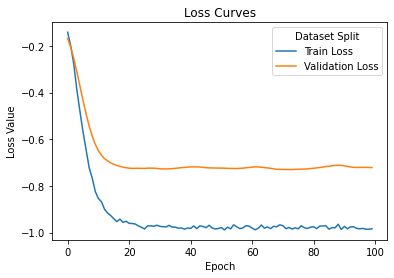

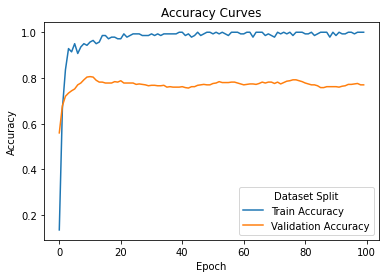

In [14]:
train(model, cora_dataset)

In [15]:
test_acc, edge_attn_info = test(model, cora_dataset)

# Save test accuracy so that we log it somewhere. Train and val accuracy are kept in the accuracy curves
args["test accuracy"] = test_acc

Test Set Accuracy: 0.7820


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


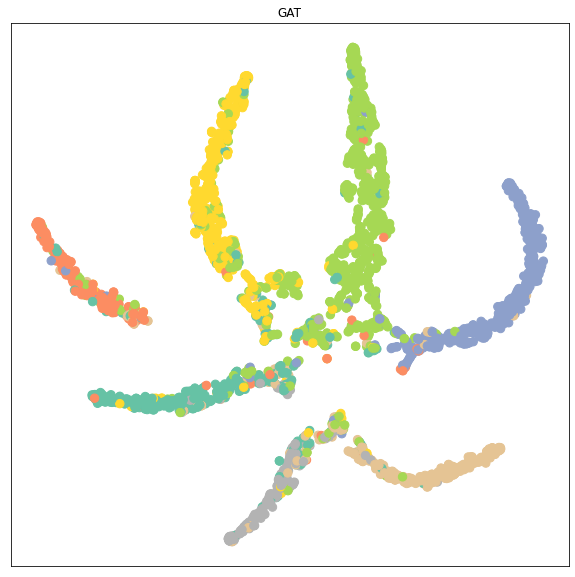

<Figure size 432x288 with 0 Axes>

In [16]:
from sklearn.manifold import TSNE
def visualize(out, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.title("GAT")
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    plt.savefig('./GAT.png',dpi=600)

out,_ = model(cora_dataset)
visualize(out, color=cora_dataset.y.detach().cpu().numpy())

## Attention scores

In [17]:
(edge_idx1, alphas1, edge_idx2, alphas2) = edge_attn_info
print(edge_idx1.shape, alphas1.shape, edge_idx2.shape, alphas2.shape)

torch.Size([2, 13264]) torch.Size([13264, 8]) torch.Size([2, 13264]) torch.Size([13264, 1])


In [18]:
print("GAT Layer 1 Attention Scores:")
for i in range(15):
    print("Average GAT attention score from node {} to node {} is {:.4f}".format(edge_idx1[0,i], edge_idx1[1,i], alphas1[i,:].mean()))

GAT Layer 1 Attention Scores:
Average GAT attention score from node 0 to node 633 is 0.2499
Average GAT attention score from node 0 to node 1862 is 0.1957
Average GAT attention score from node 0 to node 2582 is 0.2517
Average GAT attention score from node 1 to node 2 is 0.1870
Average GAT attention score from node 1 to node 652 is 0.3059
Average GAT attention score from node 1 to node 654 is 0.4317
Average GAT attention score from node 2 to node 1 is 0.1962
Average GAT attention score from node 2 to node 332 is 0.1571
Average GAT attention score from node 2 to node 1454 is 0.4457
Average GAT attention score from node 2 to node 1666 is 0.1145
Average GAT attention score from node 2 to node 1986 is 0.0140
Average GAT attention score from node 3 to node 2544 is 0.4695
Average GAT attention score from node 4 to node 1016 is 0.1641
Average GAT attention score from node 4 to node 1256 is 0.1140
Average GAT attention score from node 4 to node 1761 is 0.1088


In [19]:
print("GAT Layer 2 Attention Scores:")
for i in range(15):
    print("Average GAT attention score from node {} to node {} is {:.4f}".format(edge_idx2[0,i], edge_idx2[1,i], alphas2[i,:].mean()))

GAT Layer 2 Attention Scores:
Average GAT attention score from node 0 to node 633 is 0.2655
Average GAT attention score from node 0 to node 1862 is 0.2075
Average GAT attention score from node 0 to node 2582 is 0.2759
Average GAT attention score from node 1 to node 2 is 0.7014
Average GAT attention score from node 1 to node 652 is 0.5567
Average GAT attention score from node 1 to node 654 is 0.2433
Average GAT attention score from node 2 to node 1 is 0.0238
Average GAT attention score from node 2 to node 332 is 0.1662
Average GAT attention score from node 2 to node 1454 is 0.4368
Average GAT attention score from node 2 to node 1666 is 0.1685
Average GAT attention score from node 2 to node 1986 is 0.0243
Average GAT attention score from node 3 to node 2544 is 0.5046
Average GAT attention score from node 4 to node 1016 is 0.1520
Average GAT attention score from node 4 to node 1256 is 0.1006
Average GAT attention score from node 4 to node 1761 is 0.1386


In [20]:
alphas1.shape

torch.Size([13264, 8])

Find the relationship between large attention score and same class label

In [21]:
alphas1_average = alphas1.mean(dim=1)
alphas1_average.shape

torch.Size([13264])

In [22]:
torch.argmax(alphas1_average)

tensor(5315, device='cuda:0')

In [23]:
print("Average GAT attention score from node {} to node {} is {:.4f}".format(edge_idx1[0,1840], edge_idx1[1,1840], alphas1[1840,:].mean()))

Average GAT attention score from node 447 to node 2638 is 0.5449


In [24]:
print(cora_dataset.y[447])
print(cora_dataset.y[2638])

tensor(6, device='cuda:0')
tensor(6, device='cuda:0')


The high similarity score indeed indicated that the two nodes had the same class label. This means that when the GAT layer was computing attention between the node embeddings of nodes 447 and 2638, which were one-hot encoded words from scientific papers, the attention mechanism computed higher similarity between the word dictionary embeddings because the two papers had the same subject.

In [25]:
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
  (act1): ELU(alpha=1.0)
  (drop1): Dropout(p=0.6, inplace=False)
  (drop2): Dropout(p=0.6, inplace=False)
)
